# Простая сверточная сеть для классификации датасета Overhead MNIST

## Загрузка и подготовка данных

Начнем с загрузки датасата с kaggle. Необходимо использовать свой .json файл, чтобы открыть канал для загрузки, а также скопировать текст api команды. Ниже приводится стандартный код для загрузки датасета с kaggle.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alekseimedvedev","key":"e7e2e8ad9f177293686bb5c420c22c41"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d datamunge/overheadmnist

 99% 215M/218M [00:01<00:00, 149MB/s]
100% 218M/218M [00:01<00:00, 142MB/s]


In [ ]:
from IPython.core.display import clear_output
!unzip '/content/overheadmnist.zip' -d '/content/overheadmnist'
clear_output()

Создаем torch датасеты с помощью класса ImageFolder.

In [ ]:
datadir='/content/overheadmnist/overhead'
traindir = datadir + '/training/'
testdir = datadir + '/testing/'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [ ]:
train_transform = T.Compose([T.Resize((28,28)),T.Grayscale(), T.ToTensor()])
test_transform = T.Compose([T.Resize((28,28)),T.Grayscale(),T.ToTensor()])

In [ ]:
train_dataset=datasets.ImageFolder(traindir,transform=train_transform)
test_dataset=datasets.ImageFolder(testdir,transform=test_transform)

Зададим два итератора данных, которые разобьют выборки на случайные пакеты фиксированного размера.

In [ ]:
batch_size=32 # размер пакета
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
dataloaders = {"train": train_loader,"validation": test_loader}

In [ ]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([32, 1, 28, 28])


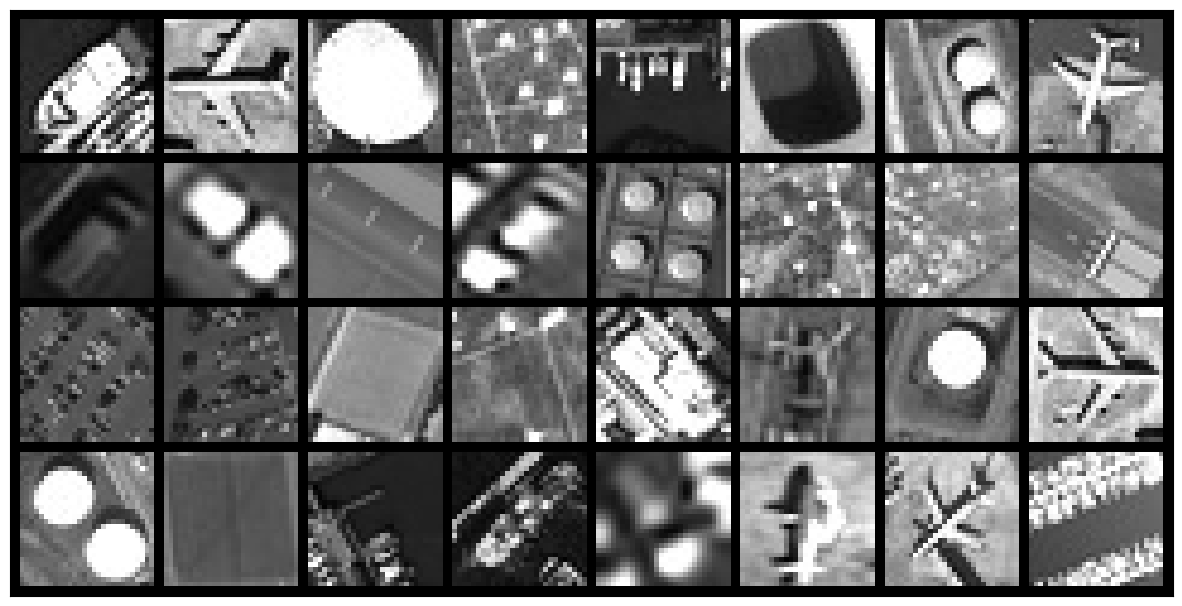

In [ ]:
show_batch(dataloaders['train'])

## Задаем модель

In [ ]:
import torch.nn as nn

class Simple_Overhead_MNIST_CNN(nn.Module):
  def __init__(self):
    super(Simple_Overhead_MNIST_CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2))
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.AvgPool2d(7))
    self.fc= nn.Linear(64,10)

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = x.view(x.size(0),-1) # или x = nn.Flatten()(x)
    x = self.fc(x)
    return x

Инициализируем модель и отправляем на вычислительный процессор.

In [ ]:
model=Simple_Overhead_MNIST_CNN()
model.to(device)

Simple_Overhead_MNIST_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0

Выведем подробную детализацию модели.

In [ ]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary
summary(model,input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Simple_Overhead_MNIST_CNN                [8, 10]                   --
├─Sequential: 1-1                        [8, 16, 14, 14]           --
│    └─Conv2d: 2-1                       [8, 16, 28, 28]           160
│    └─ReLU: 2-2                         [8, 16, 28, 28]           --
│    └─BatchNorm2d: 2-3                  [8, 16, 28, 28]           32
│    └─Conv2d: 2-4                       [8, 16, 28, 28]           2,320
│    └─ReLU: 2-5                         [8, 16, 28, 28]           --
│    └─BatchNorm2d: 2-6                  [8, 16, 28, 28]           32
│    └─MaxPool2d: 2-7                    [8, 16, 14, 14]           --
├─Sequential: 1-2                        [8, 32, 7, 7]             --
│    └─Conv2d: 2-8                       [8, 32, 14, 14]           4,640
│    └─ReLU: 2-9                         [8, 32, 14, 14]           --
│    └─BatchNorm2d: 2-10                 [8, 32, 14, 14]           64
│    └─C

## Цикл обучения модели.

Создаем цикл обучения модели.

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Для подсчета метрик, вывода графиков, матрицы ошибок, будем использовать высокоуровневую библиотеку **ignite**

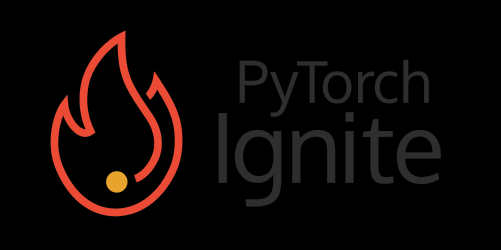

In [ ]:
!pip install pytorch-ignite --quiet

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

Задаем движок обучения.

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
metrics = { "loss" : Loss(criterion), 
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=10)}

Задаем вычисление метрик.

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

Добавляем вычисление и запись метрик по событию - конец эпохи.

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

Используем раннюю остановку: если 10 эпох подряд точность на валидационной выборке не увеличивалась, то прекращаем обучение.

In [ ]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

Сохраняем 2 лучшие по точности модели.

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=2, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

Добавим вывод шкалы прогресса (есть два режима: блокнот и консоль)

In [ ]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

В конце обучения выведем матрицу ошибок.

In [ ]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

## Запуск обучения модели

  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 81.18 Сред. ошибка: 0.55770
Результат валидации - Эпоха: 1  Сред. точность: 80.38 Сред. ошибка: 0.57581


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 91.14 Сред. ошибка: 0.28390
Результат валидации - Эпоха: 2  Сред. точность: 89.86 Сред. ошибка: 0.30568


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 93.20 Сред. ошибка: 0.21105
Результат валидации - Эпоха: 3  Сред. точность: 92.02 Сред. ошибка: 0.25308


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 94.35 Сред. ошибка: 0.17872
Результат валидации - Эпоха: 4  Сред. точность: 93.52 Сред. ошибка: 0.21625


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 91.16 Сред. ошибка: 0.25706
Результат валидации - Эпоха: 5  Сред. точность: 89.39 Сред. ошибка: 0.31834


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 96.69 Сред. ошибка: 0.10944
Результат валидации - Эпоха: 6  Сред. точность: 94.46 Сред. ошибка: 0.15859


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 96.74 Сред. ошибка: 0.10593
Результат валидации - Эпоха: 7  Сред. точность: 95.31 Сред. ошибка: 0.16093


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 96.27 Сред. ошибка: 0.11255
Результат валидации - Эпоха: 8  Сред. точность: 94.37 Сред. ошибка: 0.16971


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 95.88 Сред. ошибка: 0.13275
Результат валидации - Эпоха: 9  Сред. точность: 92.21 Сред. ошибка: 0.23734


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 98.06 Сред. ошибка: 0.06351
Результат валидации - Эпоха: 10  Сред. точность: 95.21 Сред. ошибка: 0.14436


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 97.98 Сред. ошибка: 0.06279
Результат валидации - Эпоха: 11  Сред. точность: 95.12 Сред. ошибка: 0.15422


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 98.22 Сред. ошибка: 0.05730
Результат валидации - Эпоха: 12  Сред. точность: 95.31 Сред. ошибка: 0.15249


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 98.69 Сред. ошибка: 0.04712
Результат валидации - Эпоха: 13  Сред. точность: 95.49 Сред. ошибка: 0.14474


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 98.66 Сред. ошибка: 0.03997
Результат валидации - Эпоха: 14  Сред. точность: 95.59 Сред. ошибка: 0.14048


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.15 Сред. ошибка: 0.02971
Результат валидации - Эпоха: 15  Сред. точность: 95.59 Сред. ошибка: 0.13057


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 97.83 Сред. ошибка: 0.06350
Результат валидации - Эпоха: 16  Сред. точность: 93.80 Сред. ошибка: 0.19837


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 98.07 Сред. ошибка: 0.05893
Результат валидации - Эпоха: 17  Сред. точность: 94.46 Сред. ошибка: 0.18325


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.18 Сред. ошибка: 0.02862
Результат валидации - Эпоха: 18  Сред. точность: 95.68 Сред. ошибка: 0.14740


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 98.92 Сред. ошибка: 0.03483
Результат валидации - Эпоха: 19  Сред. точность: 94.93 Сред. ошибка: 0.17074


  0%|          | 1/267 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 98.43 Сред. ошибка: 0.05396
Результат валидации - Эпоха: 20  Сред. точность: 94.27 Сред. ошибка: 0.19785


State:
	iteration: 5340
	epoch: 20
	epoch_length: 267
	max_epochs: 20
	output: 0.08075379580259323
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

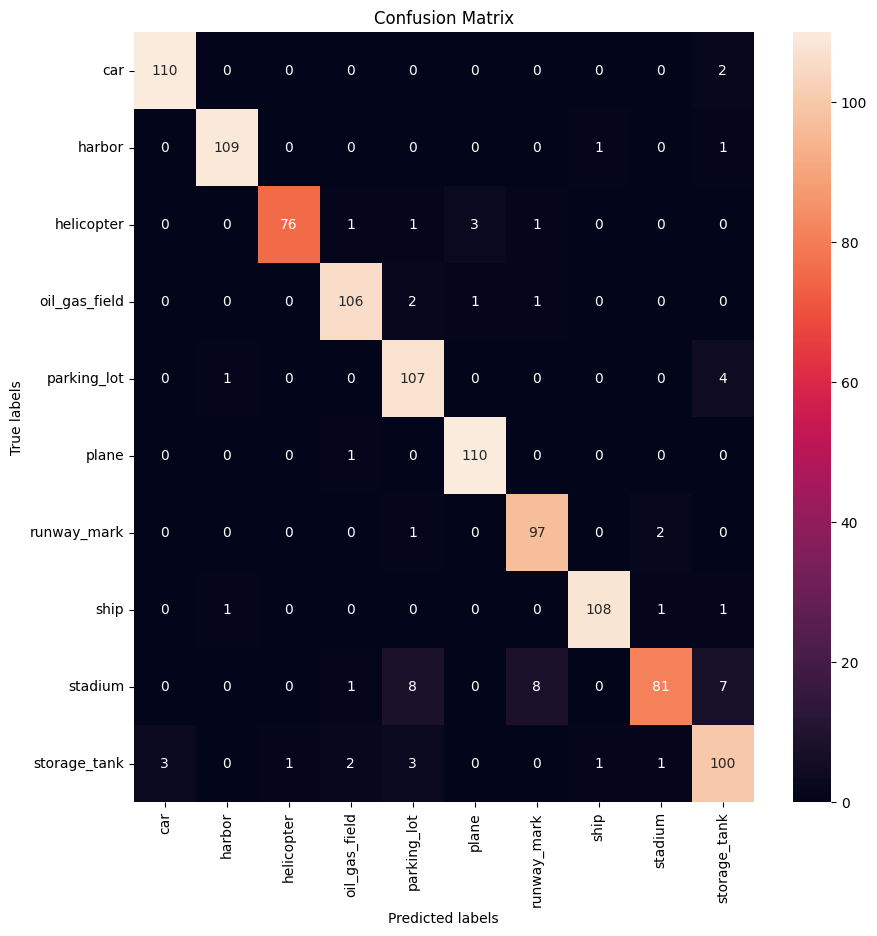

In [ ]:
trainer.run(train_loader, max_epochs=20)

## Анализ обученной модели.

Кривые обучения и валидации.

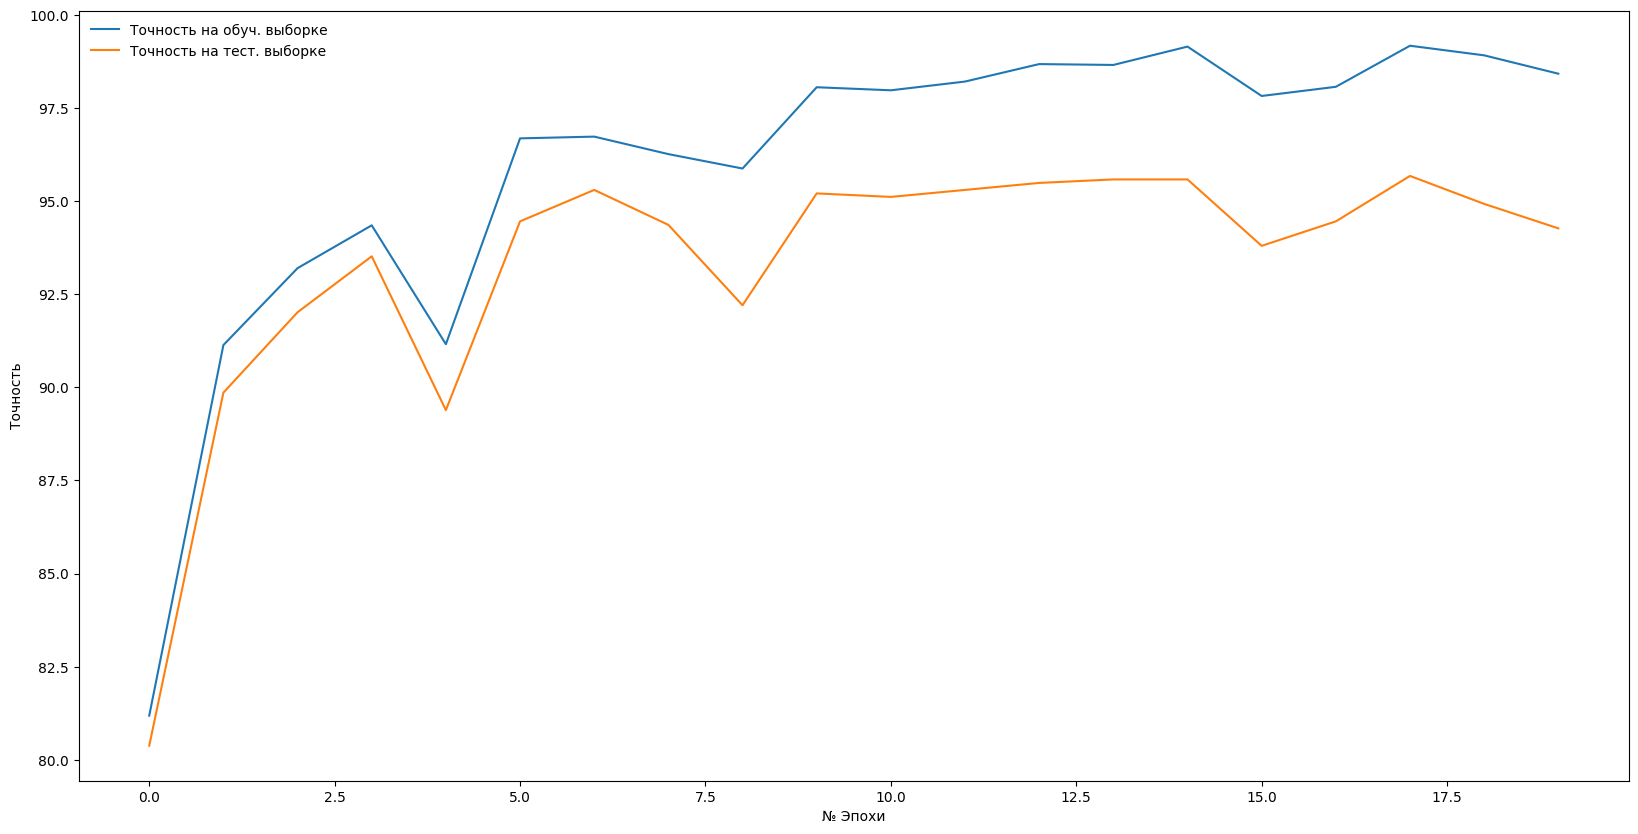

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

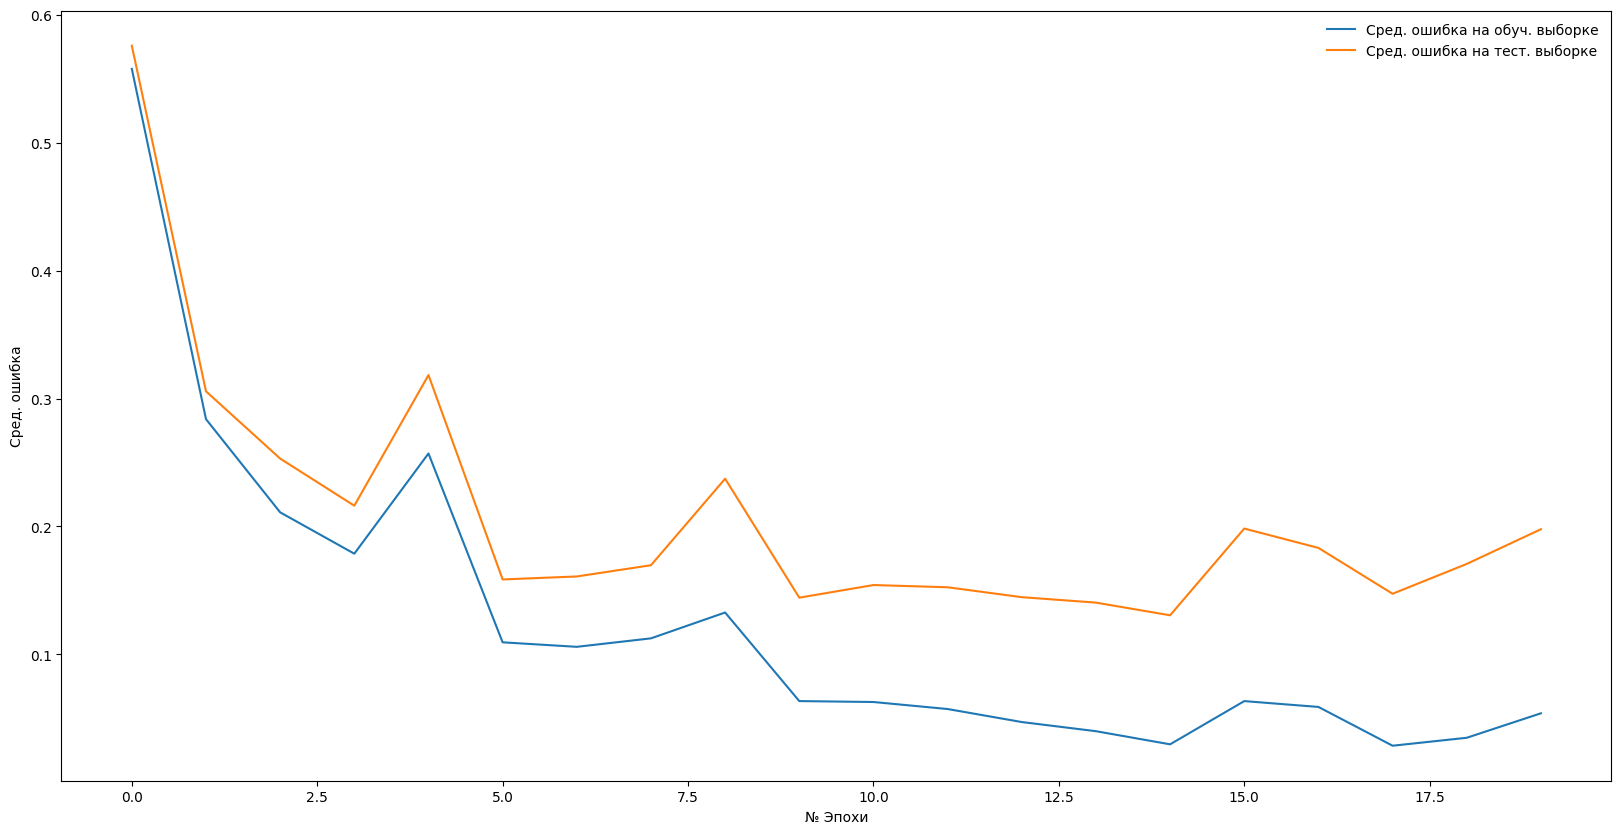

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['loss'],label="Сред. ошибка на обуч. выборке")
plt.plot(test_history['loss'],label="Сред. ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Сред. ошибка')
plt.legend(frameon=False)
plt.show()